# Conversion Rate
Les data scientists qui ont créé la newsletter souhaitent mieux comprendre le comportement des utilisateurs visitant leur site web. Ils aimeraient savoir s'il est possible de construire un modèle qui prédit si un utilisateur donné s'abonnera à la newsletter, en utilisant seulement quelques informations sur l'utilisateur. Ils souhaitent analyser les paramètres du modèle pour mettre en évidence des fonctionnalités importantes pour expliquer le comportement des utilisateurs, et peut-être découvrir un nouveau levier d'action pour améliorer le taux de conversion de la newsletter.

In [1]:
!pip install plotly -q
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error,classification_report
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

In [2]:
df = pd.read_csv('data_train.csv')
df.shape

(284580, 6)

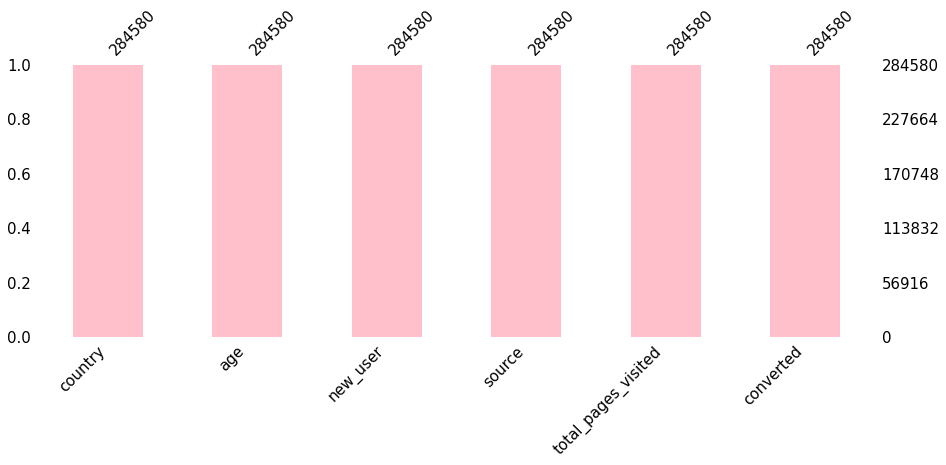

In [3]:
!pip install missingno -q
import missingno as msno
msno.bar(df,figsize=(15, 5),fontsize=15,color='pink');

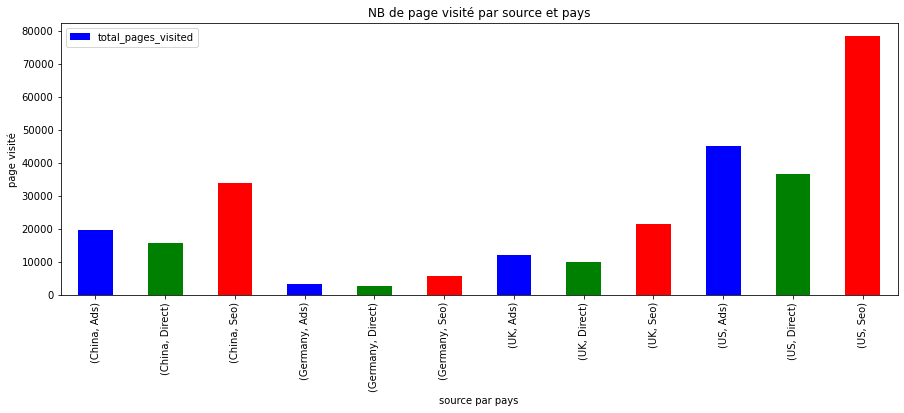

In [4]:
country_source = df.groupby(['country','source'])['total_pages_visited'].count()
country_source
country_source.plot(kind='bar',
                    title='NB de page visité par source et pays',
                    ylabel='page visité',
                    xlabel='source par pays',
                    color=['b','g','r'],
                    figsize=(15, 5),
                    legend = True)
plt.show()

On remarque que les sources les plus visitées sont SEO suivit de ADS et DIRECT dans les différants pays on visite plus de page au US et chine.

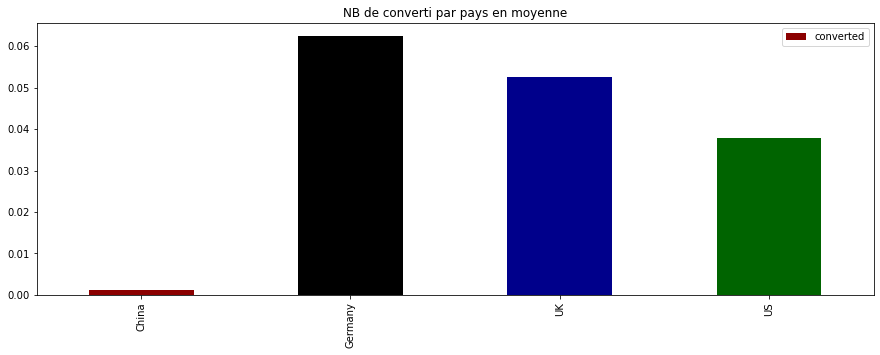

In [5]:
df_pays = df.groupby(['country']).mean()
df_pays['converted'].plot(kind='bar',
                    title='NB de converti par pays en moyenne',
                    ylabel='',
                    xlabel='',
                    color=['darkred','black','darkblue','darkgreen'],
                    figsize=(15, 5),
                    legend = True)
plt.show()

les gens se convertissent plus en Germany, Royaume-Uni suivi des États-Unis

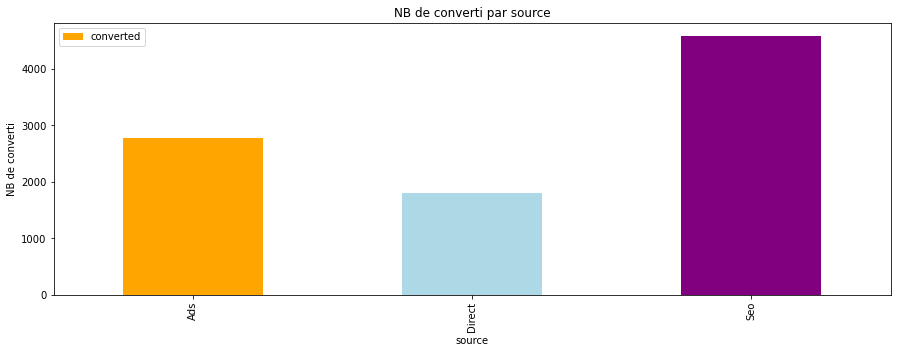

In [6]:
masq = (df['converted'] == 1)
true_converted = df.loc[masq,:]

df_pays = true_converted.groupby(['source']).count()
df_pays['converted'].plot(kind='bar',
                    title='NB de converti par source',
                    ylabel='NB de converti',
                    xlabel='source',
                    color=['orange','lightblue','purple'],
                    figsize=(15, 5),
                    legend = True)
plt.show()

On remarque également les source ou les utilisateurs se convertissent le plus sont similaire aux page visitées.

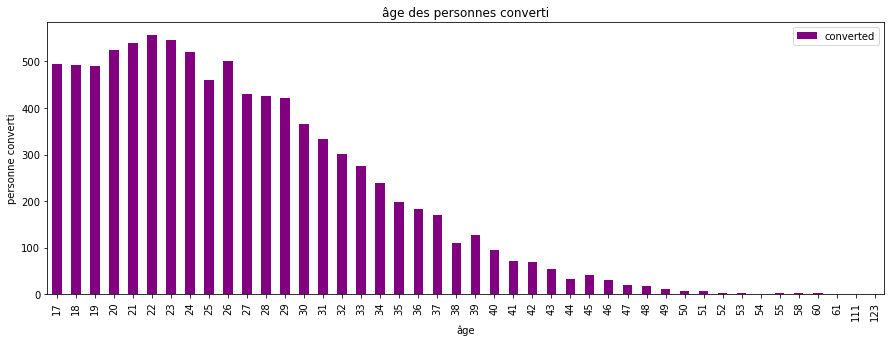

In [7]:
masq = (df['converted'] == 1)
true_converted = df.loc[masq,:]
true_converted

df_converted = true_converted.groupby(['age']).count()
df_converted['converted'].plot(kind='bar',
                    title='âge des personnes converti',
                    ylabel='personne converti',
                    xlabel='âge',
                    color=['purple'],
                    figsize=(15, 5),
                    legend = True)
plt.show()

l'age des utilisateurs converti varie principalement entre 17 et 37 ans on remarque egalement que nous avons des données aberrante avec des âge allant jusqu'a 123 ans

In [8]:
masq = (df['converted'] == 1) & (df['age'] > 70)
true_converted = df.loc[masq,:]
true_converted

,country,age,new_user,source,total_pages_visited,converted
11331,UK,111,0,Ads,10,1
233196,Germany,123,0,Seo,15,1


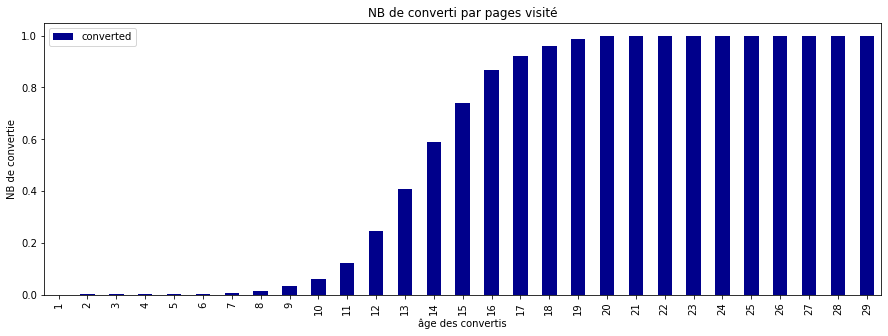

In [79]:
masq = (df['converted'] == 1)
true_converted = df.loc[masq,:]
true_converted

df_converted = df.groupby(['total_pages_visited']).mean()
df_converted['converted'].plot(kind='bar',
                    title='NB de converti par pages visité',
                    ylabel='NB de convertie',
                    xlabel='âge des convertis',
                    color=['darkblue'],
                    figsize=(15, 5),
                    legend = True)
plt.show()

On remarque qu'il y a plus de convertir plus les pages sont visitées les gens se convertisse à partir de 16 pages visitées

In [10]:
masq = (df['age'] < 70)
true_converted = df.loc[masq,:]
df=true_converted 


# PREDICTION MODELS

In [70]:
#on defini X et Y 
target_name = 'converted'
Y = df.loc[:,target_name]
X = df.loc[:,[c for c in df.columns if c!=target_name]]
print(X)
# Divide dataset Train set & Test set 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

        country  age  new_user  source  total_pages_visited
0         China   22         1  Direct                    2
1            UK   21         1     Ads                    3
2       Germany   20         0     Seo                   14
3            US   23         1     Seo                    3
4            US   28         1  Direct                    3
...         ...  ...       ...     ...                  ...
284575       US   36         1     Ads                    1
284576       US   31         1     Seo                    2
284577       US   41         1     Seo                    5
284578       US   31         1  Direct                    4
284579       US   26         0     Ads                    3

[284572 rows x 5 columns]


In [71]:
#Convert pandas DataFrames to numpy arrays...
X_train = X_train.values
X_test = X_test.values
Y_train = Y_train.tolist()
Y_test = Y_test.tolist()

In [72]:
# Create pipeline for numeric features
numeric_features = [1, 4] # Positions of numeric columns in X_train/X_test
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # if still missing values we will replace by columns' mean
    ('scaler', StandardScaler())
])

# Create pipeline for categorical features
categorical_features = [0, 2, 3] # Positions of categorical columns in X_train/X_test
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # if still missing values we will replace by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

In [73]:
#OHE
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings on train and test set
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test) # Don't fit again on test!!

In [74]:
# Train model
classifierR = LogisticRegression()
classifierR.fit(X_train, Y_train) # Training is always done on train set !!

# Predictions on training set
y_train_pred = classifierR.predict(X_train)
# Predictions on test set
y_test_pred = classifierR.predict(X_test)

In [75]:
print("f1-score on train set : %.3f" % f1_score(Y_train, y_train_pred))
print("f1-score on test set : %.3f" % f1_score(Y_test, y_test_pred))

f1-score on train set : 0.764
f1-score on test set : 0.760


Test set
La matrice de confusion montre que le modèle semble assez robuste sur l'ensemble de test aussi


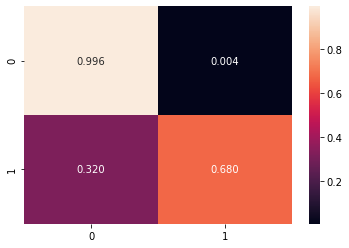

In [76]:
print('Test set')
cm = confusion_matrix(Y_test, y_test_pred, normalize="true")
sns.heatmap(cm, annot=True, fmt=".3f");
print("La matrice de confusion montre que le modèle semble assez robuste sur l'ensemble de test aussi")

Dans les données de test, le nombre de non convertie classé comme non convertie  corespond à 99,6 %.
Dans les données de test, le nombre de converti classé comme converti est correct à 68 %.

on constate également que nous avons un biais de 32% ou les converties sont classé comme non converti

In [77]:
# Computing other performance metrics to better understand what the model is doing : Classifier
print(classification_report(Y_test, classifierR.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55086
           1       0.86      0.68      0.76      1829

    accuracy                           0.99     56915
   macro avg       0.93      0.84      0.88     56915
weighted avg       0.99      0.99      0.99     56915



Nous avons 99% de chance pour la classe 0 et 86% de chance pour la classe 1 qu'elle soit bien 0 et 1.
De plus nous avons 100% de tout les non convertis que nous arrivons à bien prédire comme non converti, et 68% pour prédit comme bien converti.

Le F1-score prend en compte la moyenne du déséquilibre entre le recall et la précision avec un F1-score à 99% et 76% montre l'exactitude de nos 2 metriques précédentes.

Dans le support on remarque un désequilibre entre les 2 classes nous avons beaucoup plus de 0 que de 1

# Arbre de décision

In [20]:
# Create a random tree
classifier = DecisionTreeClassifier()
classifier.fit(X_train, Y_train)

DecisionTreeClassifier()

In [21]:
# Determining best hyperparameters
max_depth = [7, 8, 9,10]
min_samples_split = [10,11,12,13]

dt_grid = GridSearchCV(estimator=DecisionTreeClassifier(), cv=3,
                       param_grid={"max_depth":max_depth, "min_samples_split":min_samples_split})

dt_grid.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [7, 8, 9, 10],
                         'min_samples_split': [10, 11, 12, 13]})

In [22]:
print("Hyperparameters that give the best score : ", dt_grid.best_params_)
print("Best score : %.3f" % dt_grid.best_score_)

Hyperparameters that give the best score :  {'max_depth': 8, 'min_samples_split': 12}
Best score : 0.985


In [23]:
# Apply the grid search outputs into the Decision Tree Classifier
dt = DecisionTreeClassifier(max_depth=dt_grid.best_params_['max_depth'],
                           min_samples_split=dt_grid.best_params_['min_samples_split'])
dt.fit(X_train, Y_train)

# Predictions on training set
y_train_pred = dt.predict(X_train)

# Predictions on test set
y_test_pred = dt.predict(X_test)

In [24]:
# The f1-score will be used to assess the performances on the leaderboard
print("f1-score on train set : %.3f" % f1_score(Y_train, dt.predict(X_train)))
print("f1-score on test set : %.3f" % f1_score(Y_test, dt.predict(X_test)))

f1-score on train set : 0.765
f1-score on test set : 0.746


TEST SET : RANDOM TREE
---
The confusion matrix shows that the model random tree seems pretty robust on test set!


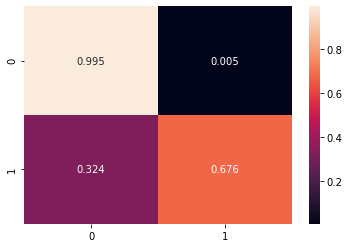

In [25]:
print('TEST SET : RANDOM TREE')
print('---')
cm = confusion_matrix(Y_test, y_test_pred, normalize="true")

sns.heatmap(cm, annot=True, fmt=".3f");
print('The confusion matrix shows that the model random tree seems pretty robust on test set!')

Dans les données de test, le nombre de non convertie classé comme non convertie  corespond à 99,5 %.
Dans les données de test, le nombre de converti classé comme converti est correct à 67 %.

on constate également que nous avons un biais de 32% ou les converties sont classé comme non converti

In [26]:
# Computing other performance metrics to better understand what the model is doing : random tree
print(classification_report(Y_test, dt.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55086
           1       0.83      0.68      0.75      1829

    accuracy                           0.99     56915
   macro avg       0.91      0.84      0.87     56915
weighted avg       0.98      0.99      0.98     56915



Nous avons 99% de chance pour la classe 0 et 83% de chance pour la classe 1 qu'elle soit bien 0 et 1.

De plus nous avons 100% de tout les non convertis que nous arrivons à bien prédire comme non converti, et 68% pour prédit comme bien converti.

Le F1-score prend en compte la moyenne du déséquilibre entre le recall et la précision avec un F1-score à 99% et 75% montre l'exactitude de nos 2 metriques précédentes.

In [27]:
# Performing predictions with Random Tree and creating a csv file

Y_predictions = pd.DataFrame(columns=['converted'],data=y_test_pred)
Y_predictions.to_csv('conversion_data_train_predictions_Decision_Tree.csv', index=False)

# random forest 

In [28]:
classifier = RandomForestClassifier()
classifier.fit(X_train, Y_train)

RandomForestClassifier()

In [29]:
# Determining best hyperparameters
max_depth = [9,10,15,20]
min_samples_split = [40,50,60,70]
n_estimators = (45,50,60,70)

rf_grid = GridSearchCV(estimator=RandomForestClassifier(), cv=3,
                       param_grid={"max_depth":max_depth,
                                   "min_samples_split":min_samples_split,
                                   "n_estimators":n_estimators})

rf_grid.fit(X_train, Y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [9, 10, 15, 20],
                         'min_samples_split': [40, 50, 60, 70],
                         'n_estimators': (45, 50, 60, 70)})

In [30]:
print("Hyperparameters that give the best score : ", rf_grid.best_params_)
print("Best score : %.3f" % rf_grid.best_score_)

Hyperparameters that give the best score :  {'max_depth': 10, 'min_samples_split': 60, 'n_estimators': 60}
Best score : 0.986


In [31]:
rf = RandomForestClassifier(n_estimators = rf_grid.best_params_['n_estimators'], max_depth=rf_grid.best_params_['max_depth'],
                           min_samples_split=rf_grid.best_params_['min_samples_split'])
rf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=10, min_samples_split=60, n_estimators=60)

In [32]:
rf_grid.best_params_

{'max_depth': 10, 'min_samples_split': 60, 'n_estimators': 60}

In [33]:
# Predictions on training set
y_train_pred = rf.predict(X_train)

# Predictions on test set
y_test_pred = rf.predict(X_test)

In [34]:
print("f1-score on train set : %.3f" % f1_score(Y_train, rf.predict(X_train)))
print("f1-score on test set : %.3f" % f1_score(Y_test, rf.predict(X_test)))

f1-score on train set : 0.770
f1-score on test set : 0.760


TEST SET : RANDOM FOREST
---


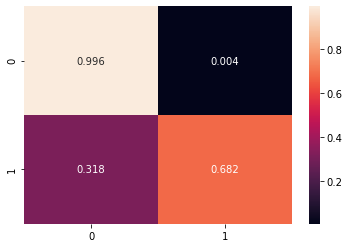

In [35]:

print('TEST SET : RANDOM FOREST')
print('---')
cm = confusion_matrix(Y_test, y_test_pred, normalize="true")

sns.heatmap(cm, annot=True, fmt=".3f");

Dans les données de test, le nombre de non convertie classé comme non convertie  corespond à 99,6 %.
Dans les données de test, le nombre de converti classé comme converti est correct à 68 %.

on constate également que nous avons un biais de 31% ou les converties sont classé comme non converti

In [36]:
# Computing other performance metrics to better understand what the model is doing : random forest
print(classification_report(Y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     55086
           1       0.86      0.68      0.76      1829

    accuracy                           0.99     56915
   macro avg       0.92      0.84      0.88     56915
weighted avg       0.99      0.99      0.99     56915



Nous avons 99% de chance pour la classe 0 et 86% de chance pour la classe 1 qu'elle soit bien 0 et 1.
De plus nous avons 100% de tout les non convertis que nous arrivons à bien prédire comme non converti, et 68% pour prédit comme bien converti.

Le F1-score prend en compte la moyenne du déséquilibre entre le recall et la précision avec un F1-score à 99% et 76% montre l'exactitude de nos 2 metriques précédentes.


# Utilisons notre meilleur modèle sur toutes les données 

In [37]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifierR.fit(X,Y)

LogisticRegression()

In [38]:
# Read data without labels
data_without_labels = pd.read_csv('data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

#features_list = ['total_pages_visited']
X_without_labels = data_without_labels.loc[:, data_without_labels.columns]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
[['UK' 28 0 'Seo' 16]
 ['UK' 22 1 'Direct' 5]
 ['China' 32 1 'Seo' 1]
 ['US' 32 1 'Ads' 6]
 ['China' 25 0 'Seo' 3]]


In [39]:
# Create pipeline for categorical features
categorical_features = [0, 2, 3]
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # if still missing values we will replace by most frequent value
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

# Create pipeline for numeric features
numeric_features = [1, 4] 
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), # if still missing values we will replace by columns' mean
    ('scaler', StandardScaler())
])

# Use ColumnTranformer to make a preprocessor object that describes all the treatments to be done
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

X_without_labels = preprocessor.fit_transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

...Done
[[-0.31512217  3.33913917  0.          1.          0.          0.
   0.          1.        ]
 [-1.03657046  0.03888347  0.          1.          0.          1.
   1.          0.        ]
 [ 0.16584336 -1.16120951  0.          0.          0.          1.
   0.          1.        ]
 [ 0.16584336  0.33890671  0.          0.          1.          1.
   0.          0.        ]
 [-0.67584631 -0.56116302  0.          0.          0.          0.
   0.          1.        ]]


In [40]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifierR.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_EXAMPLE.csv', index=False)
